In [1]:
import xarray as xr
import numpy as np
from sklearn.cluster import KMeans


### With Mean and Standard Deviation as Features from the Forcings

In [2]:
ds = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Wflow/models/adg1km_eobs/staticmaps.nc")

# Select specific data variables by name
selected_vars = ['wflow_dem', 'Slope', 'thetaS', 'SoilThickness', 'KsatVer', 'Swood', 'Sl', 'M']  # Replace with your variable names
new_ds = ds[selected_vars]
#mask = ~np.isnan(new_ds)

var = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Wflow/models/adg1km_eobs/forcings.nc")

var_mean = var.mean(dim='time').rename({'precip': 'precip_mean', 'pet': 'PET_mean', 'temp': 'temp_mean'})
var_std = var.std(dim='time').rename({'precip': 'precip_std', 'pet': 'PET_std', 'temp': 'temp_std'})

merged_ds = xr.merge([new_ds, var_mean, var_std])
merged_ds

merged_ds_fill = merged_ds.fillna(9999)
ds = merged_ds_fill
lat_lon_flat = ds.to_array().stack(points=('latitude', 'longitude')).T.values



/home/sdhinakaran/micromamba/envs/check/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


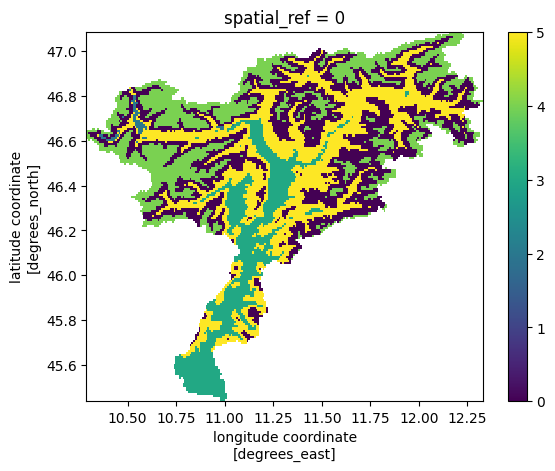

In [3]:
n_clusters = 6  # Example: Set number of clusters to 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(lat_lon_flat)

cluster_labels = kmeans.labels_

clustered_map = cluster_labels.reshape(ds.sizes['latitude'], ds.sizes['longitude'])

clustered_da = xr.DataArray(clustered_map, coords=[ds['latitude'], ds['longitude']], dims=['latitude', 'longitude'])

mask = ~np.isnan(new_ds['wflow_dem'])
clustered_das = clustered_da.where(mask)
clustered_das.plot()

<Axes: >

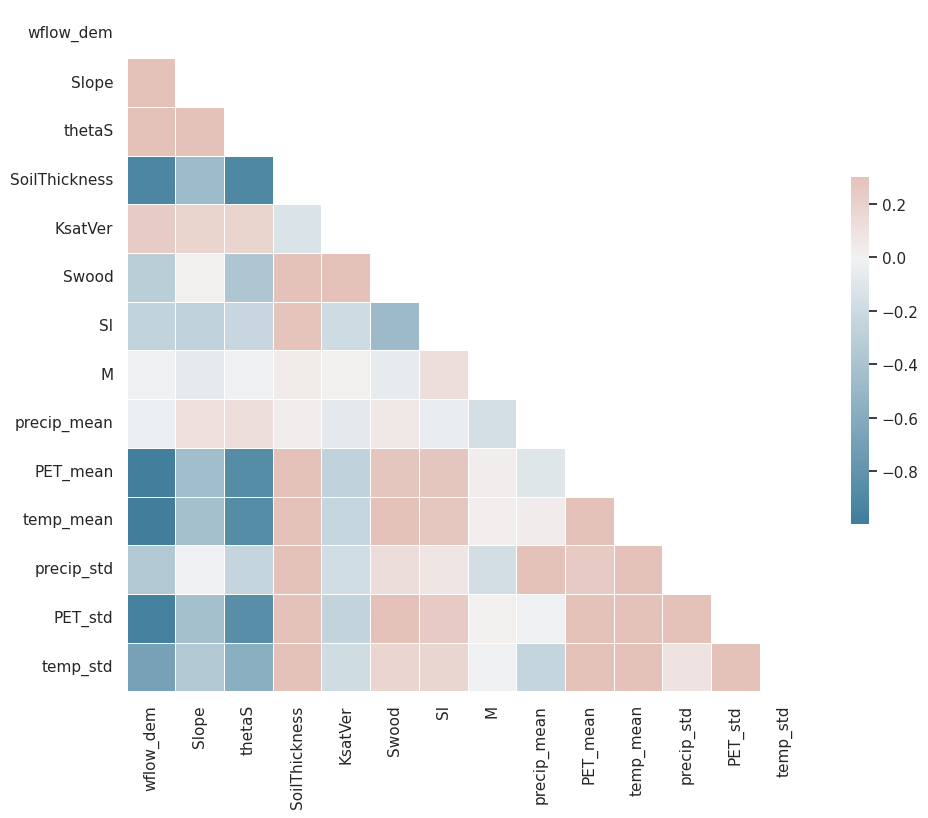

In [4]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

d = pd.DataFrame({
    var: merged_ds[var].values.flatten()
    for var in merged_ds.data_vars
})

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [5]:
merged_ds['clusters'] = clustered_das


In [6]:
# Step 2: Min-Max scale each data variable in the dataset
def min_max_scale(da):
    """Scale a DataArray using Min-Max scaling to the range 0-1."""
    return (da - da.min()) / (da.max() - da.min())

# Apply min-max scaling to each variable
scaled_ds = merged_ds.apply(min_max_scale)

print("\nScaled Dataset:")
scaled_ds

scaled_ds['clusters'] = clustered_das




Scaled Dataset:


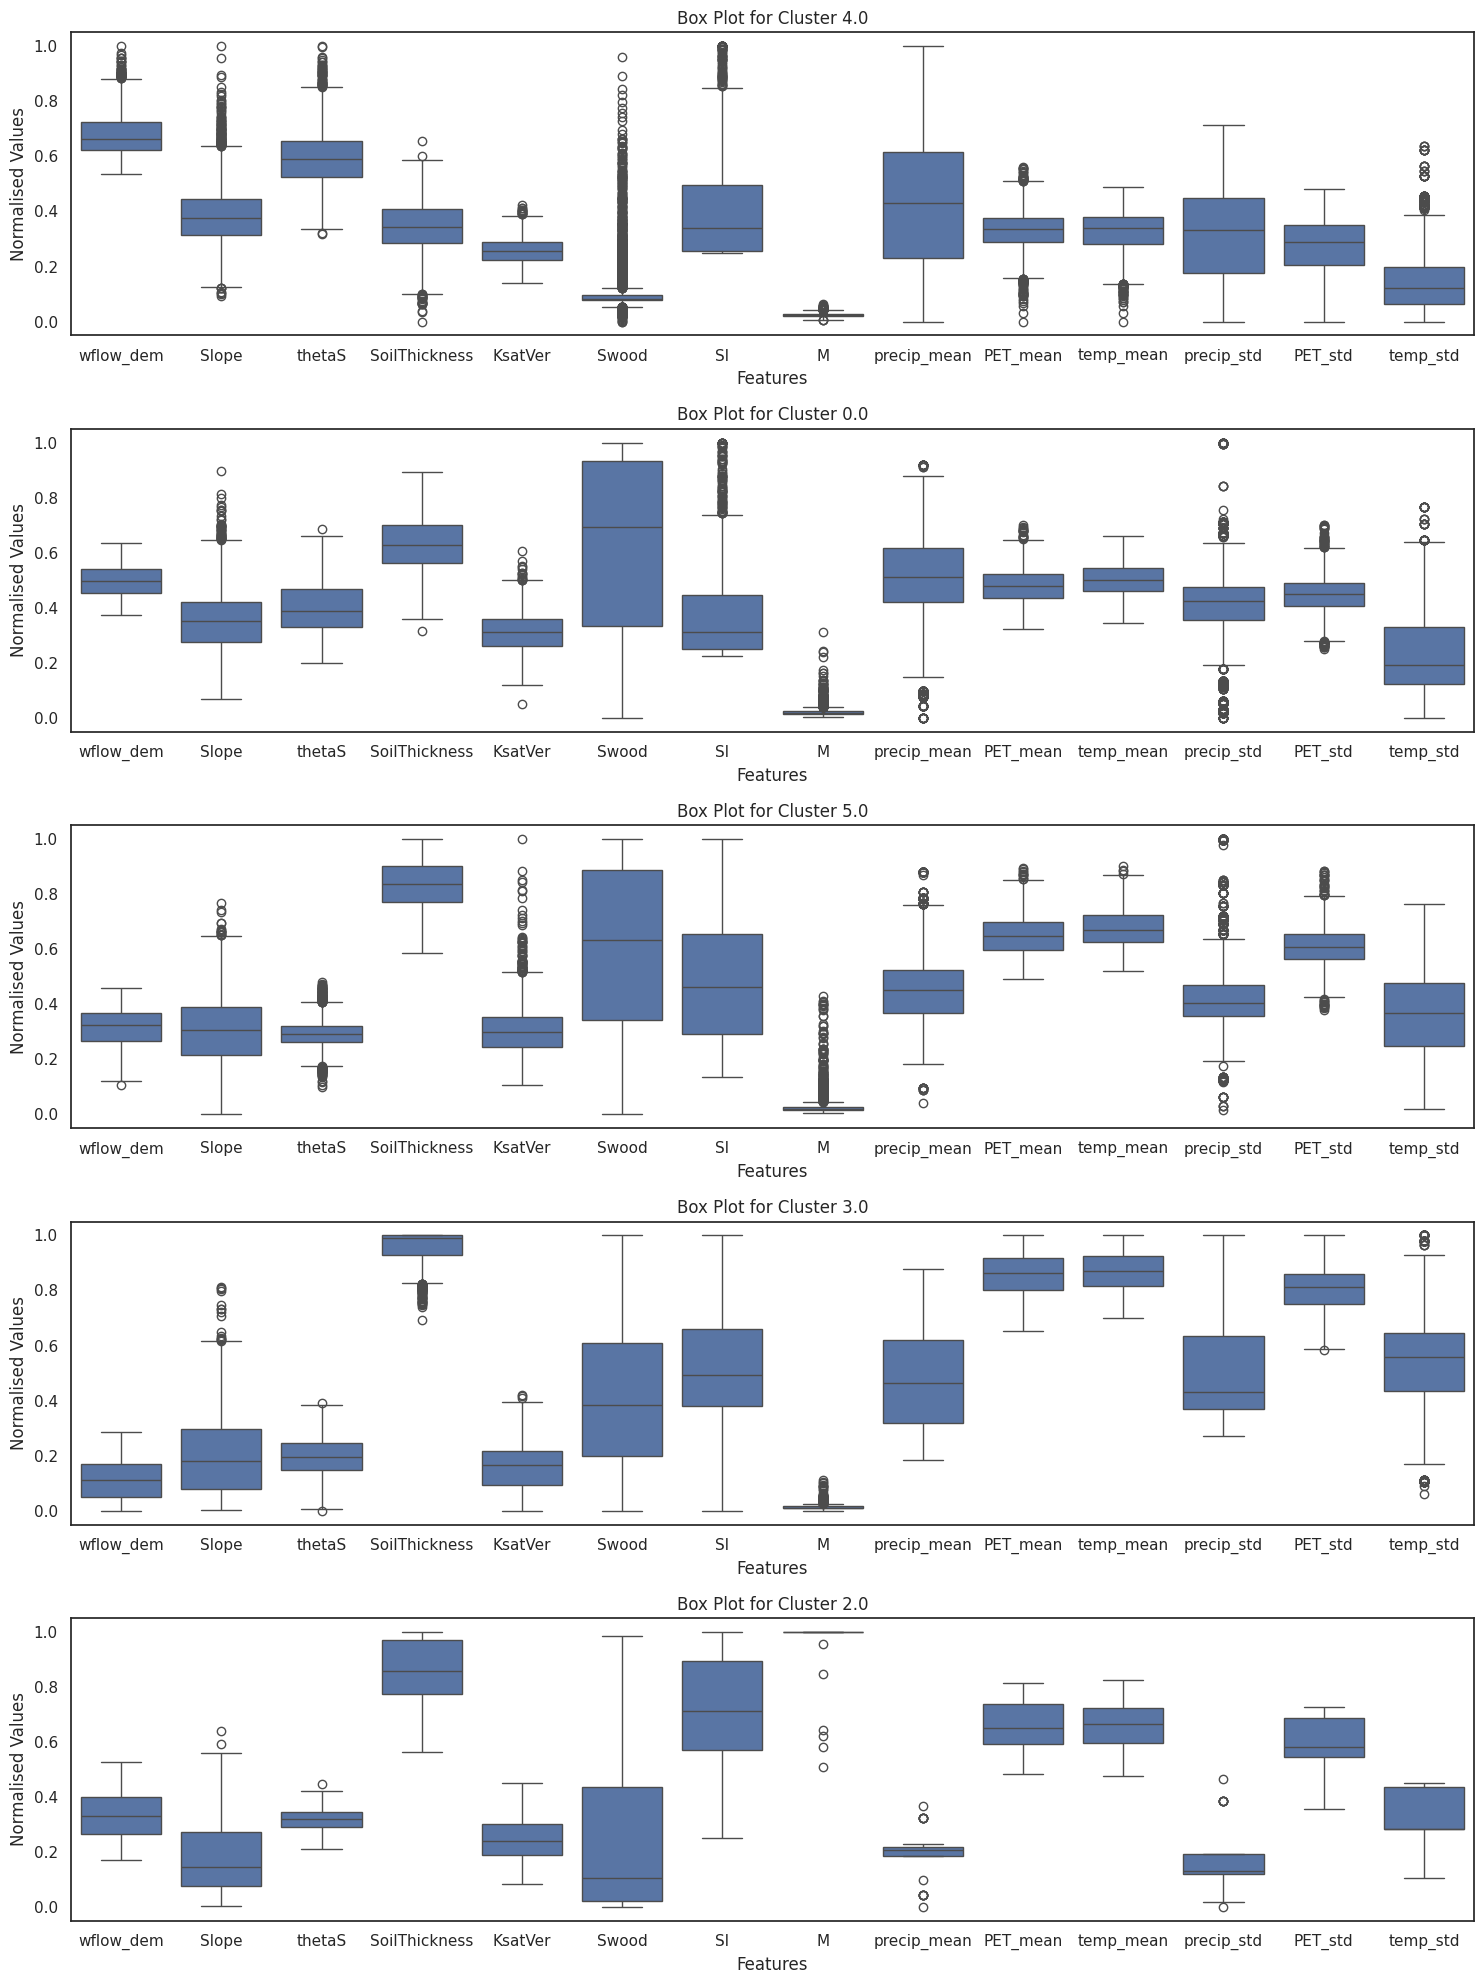

In [7]:
# Step 2: Convert the xarray Dataset to a Pandas DataFrame
df = scaled_ds.to_dataframe().reset_index()

# Step 3: Melt the DataFrame, excluding 'cluster' and coordinate columns
feature_columns = [col for col in df.columns if col not in ['clusters', 'latitude', 'longitude', 'spatial_ref']]
df_melted = df.melt(id_vars='clusters', value_vars=feature_columns, var_name='feature', value_name='value')

# Step 4: Create separate box plots for each cluster
clusters = df['clusters'].dropna().unique()
n_clusters = len(clusters)
plt.figure(figsize=(15, 4 * n_clusters))

for i, cluster in enumerate(clusters, 1):
    plt.subplot(n_clusters, 1, i)
    sns.boxplot(x='feature', y='value', data=df_melted[df_melted['clusters'] == cluster])
    plt.title(f'Box Plot for Cluster {cluster}')
    plt.xlabel('Features')
    plt.ylabel('Normalised Values')

plt.tight_layout()
plt.show()

### With 10th Quantile and 90th Quantiles as Features from the Forcings

In [8]:
ds_q = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Wflow/models/adg1km_eobs/staticmaps.nc")

# Select specific data variables by name
selected_vars = ['wflow_dem', 'Slope', 'thetaS', 'SoilThickness', 'KsatVer', 'Swood', 'Sl', 'M']  # Replace with your variable names
new_ds = ds_[selected_vars]
#mask = ~np.isnan(new_ds)

var = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Wflow/models/adg1km_eobs/forcings.nc")

var_percentile_10 = var.quantile(0.1, dim='time').rename({'precip': 'precip_10', 'pet': 'PET_10', 'temp': 'temp_10'})
var_percentile_10 = var_percentile_10.drop_vars("quantile")
var_percentile_90 = var.quantile(0.9, dim='time').rename({'precip': 'precip_90', 'pet': 'PET_90', 'temp': 'temp_90'})
var_percentile_90 = var_percentile_90.drop_vars("quantile")


/home/sdhinakaran/micromamba/envs/check/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


In [9]:
merged_ds = xr.merge([new_ds, var_percentile_10, var_percentile_90])
merged_ds

merged_ds_fill = merged_ds.fillna(9999)
ds = merged_ds_fill
lat_lon_flat = ds.to_array().stack(points=('latitude', 'longitude')).T.values

/home/sdhinakaran/micromamba/envs/check/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


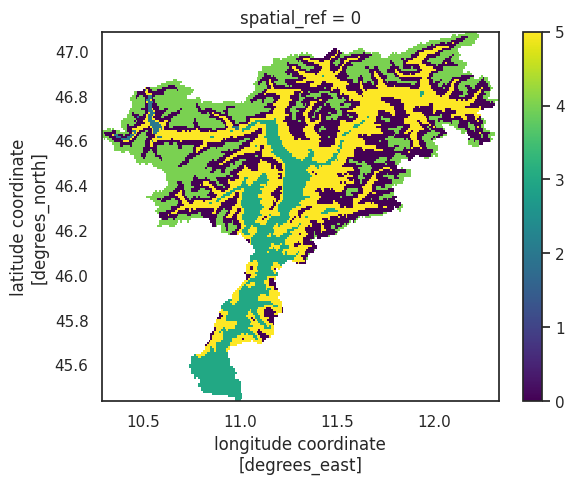

In [10]:
n_clusters = 6  # Example: Set number of clusters to 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(lat_lon_flat)

cluster_labels = kmeans.labels_

clustered_map = cluster_labels.reshape(ds.sizes['latitude'], ds.sizes['longitude'])

clustered_da = xr.DataArray(clustered_map, coords=[ds['latitude'], ds['longitude']], dims=['latitude', 'longitude'])

mask = ~np.isnan(new_ds['wflow_dem'])
clustered_das = clustered_da.where(mask)
clustered_das.plot()

<Axes: >

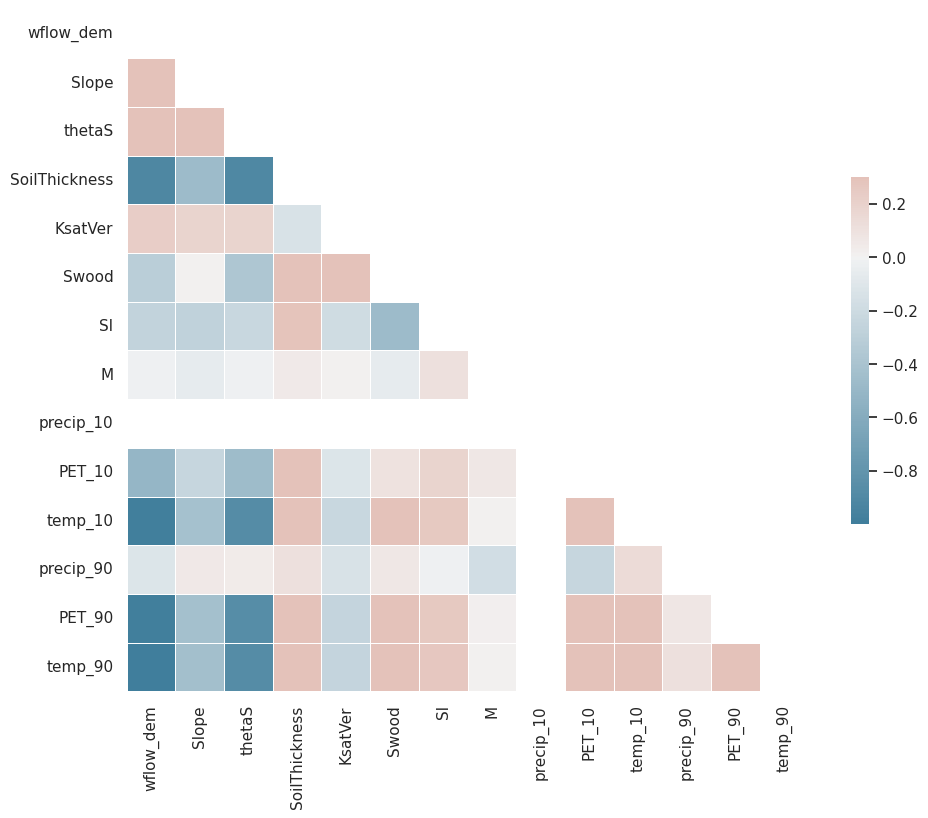

In [11]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

d = pd.DataFrame({
    var: merged_ds[var].values.flatten()
    for var in merged_ds.data_vars
})

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [12]:
merged_ds['clusters'] = clustered_das


In [13]:
# Step 2: Min-Max scale each data variable in the dataset
def min_max_scale(da):
    """Scale a DataArray using Min-Max scaling to the range 0-1."""
    return (da - da.min()) / (da.max() - da.min())

# Apply min-max scaling to each variable
scaled_ds = merged_ds.apply(min_max_scale)

print("\nScaled Dataset:")
scaled_ds

scaled_ds['clusters'] = clustered_das




Scaled Dataset:


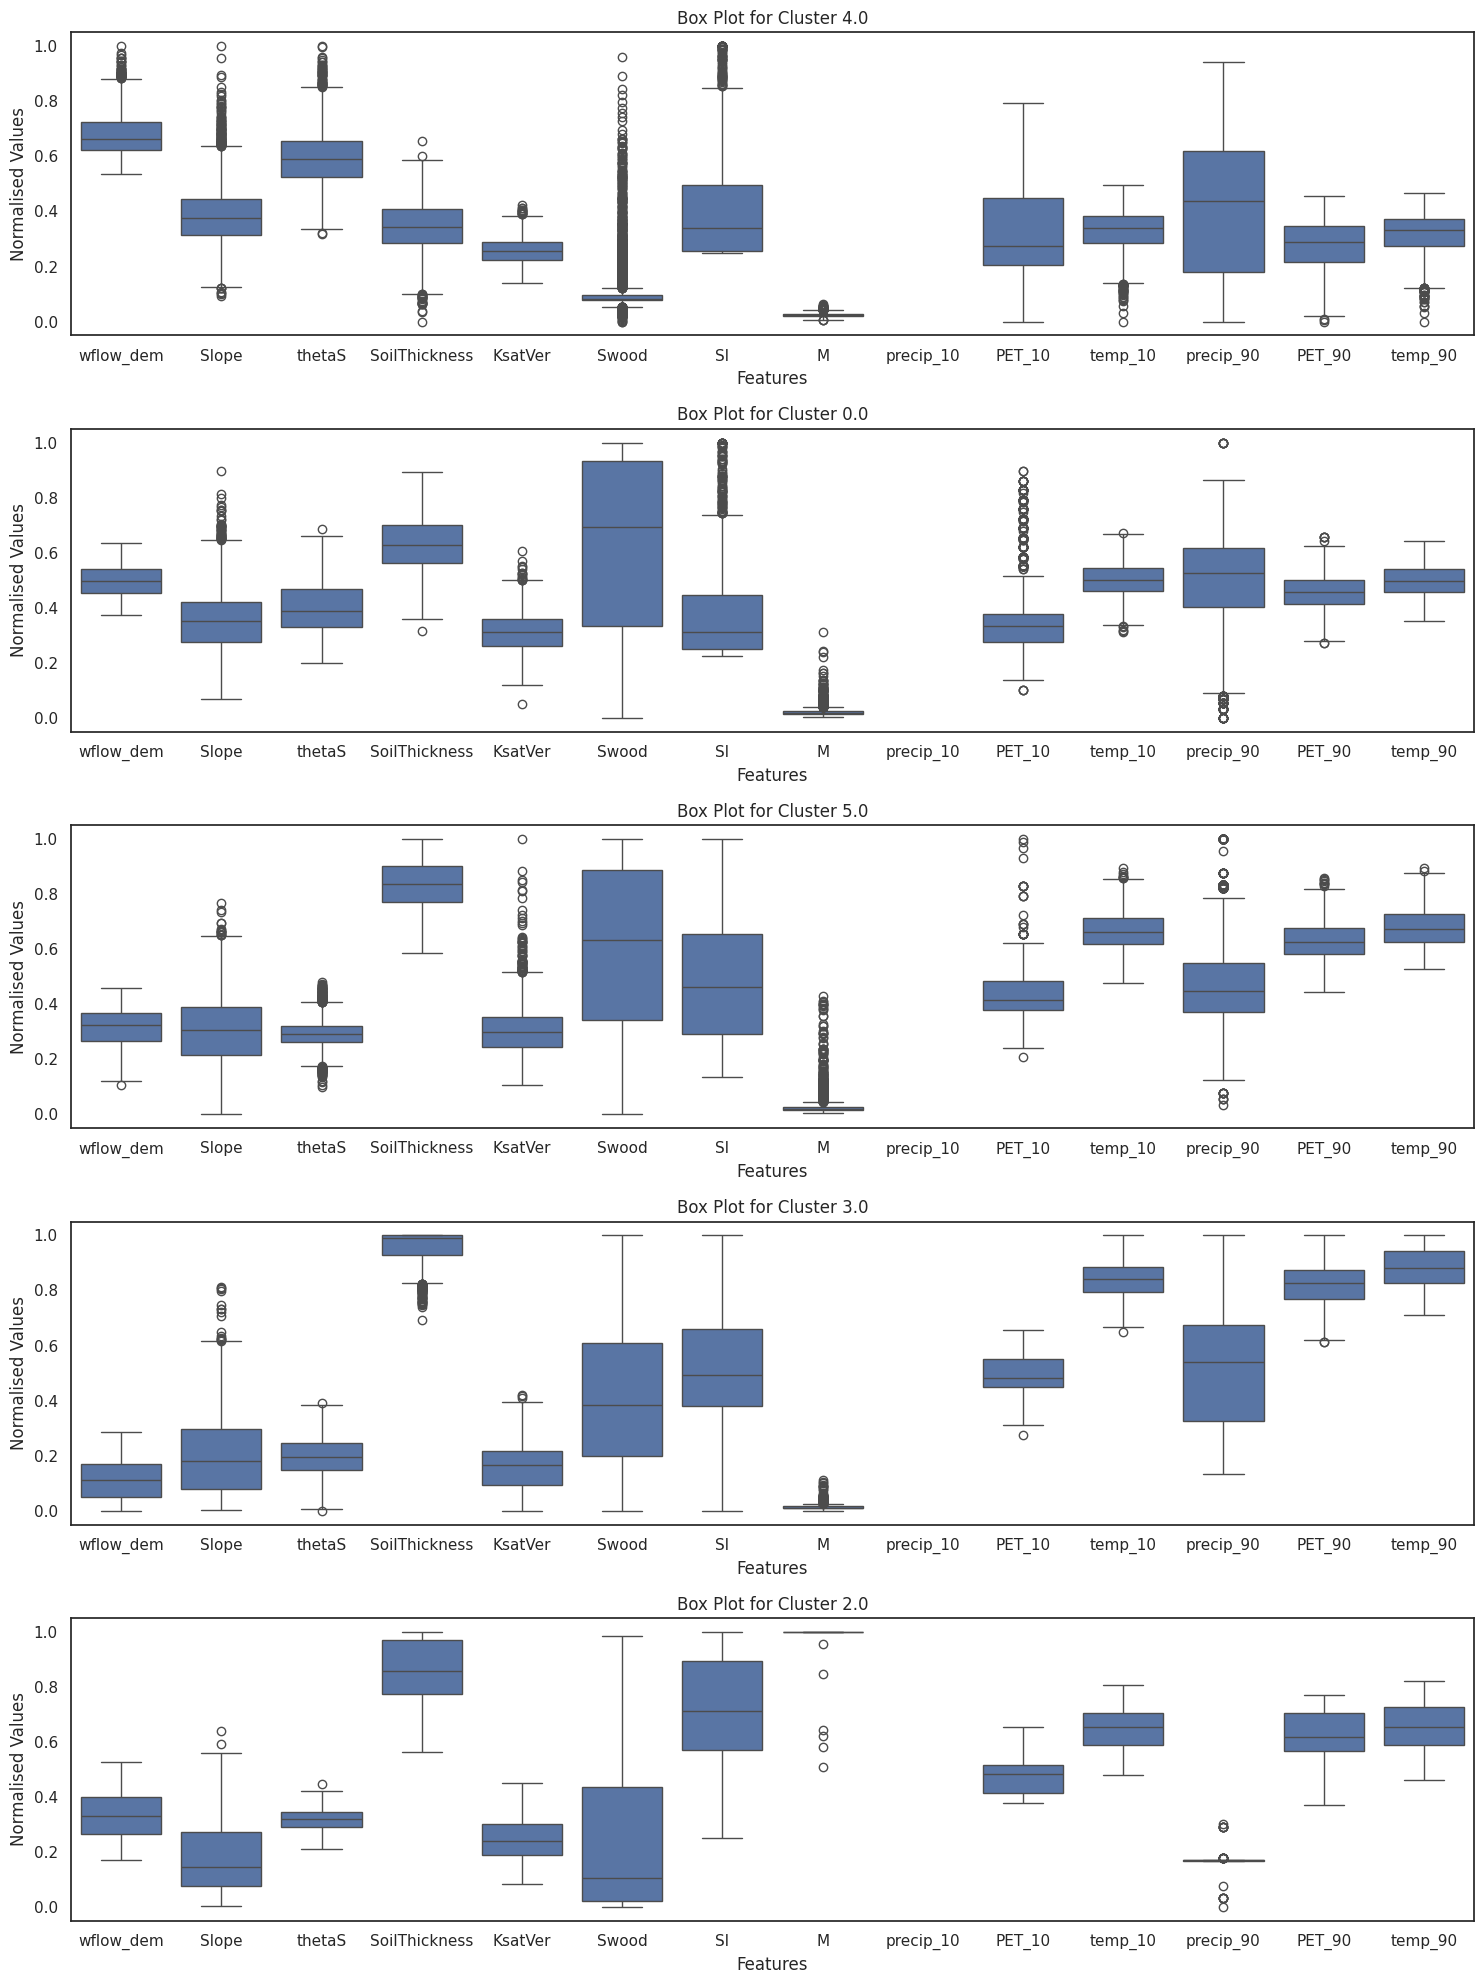

In [14]:
# Step 2: Convert the xarray Dataset to a Pandas DataFrame
df = scaled_ds.to_dataframe().reset_index()

# Step 3: Melt the DataFrame, excluding 'cluster' and coordinate columns
feature_columns = [col for col in df.columns if col not in ['clusters', 'latitude', 'longitude', 'spatial_ref']]
df_melted = df.melt(id_vars='clusters', value_vars=feature_columns, var_name='feature', value_name='value')

# Step 4: Create separate box plots for each cluster
clusters = df['clusters'].dropna().unique()
n_clusters = len(clusters)
plt.figure(figsize=(15, 4 * n_clusters))

for i, cluster in enumerate(clusters, 1):
    plt.subplot(n_clusters, 1, i)
    sns.boxplot(x='feature', y='value', data=df_melted[df_melted['clusters'] == cluster])
    plt.title(f'Box Plot for Cluster {cluster}')
    plt.xlabel('Features')
    plt.ylabel('Normalised Values')

plt.tight_layout()
plt.show()